In [22]:
# In[1]: Setup project path and imports
import sys, os
from pathlib import Path

# If this notebook sits in notebooks/, project root is parent; otherwise cwd
cwd = Path().resolve()
project_root = cwd.parent if cwd.name == "notebooks" else cwd
sys.path.insert(0, str(project_root))

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from src.backtest.backtest_engine import BacktestEngine
from src.utils.config import Config


In [23]:
# In[1b]: Clear any cached YAML so updates in configs/*.yaml are reloaded
Config._cache.clear()


In [24]:
# In[2]: Instantiate engine and run backtest
engine = BacktestEngine()
engine.compute_anomaly_score()
engine.generate_signals()
results = engine.run_backtest()

# Grab the anomaly z-score Series
anomaly = engine.anomaly


2025-04-24 00:28:32,356 [INFO] src.features.residuals: Loaded residuals: 1244 rows × 2 symbols
2025-04-24 00:28:32,359 [INFO] src.backtest.backtest_engine: Computed anomaly z-score series
2025-04-24 00:28:32,360 [INFO] src.backtest.backtest_engine: Generated trading signals
2025-04-24 00:28:32,363 [INFO] src.backtest.backtest_engine: Backtest complete


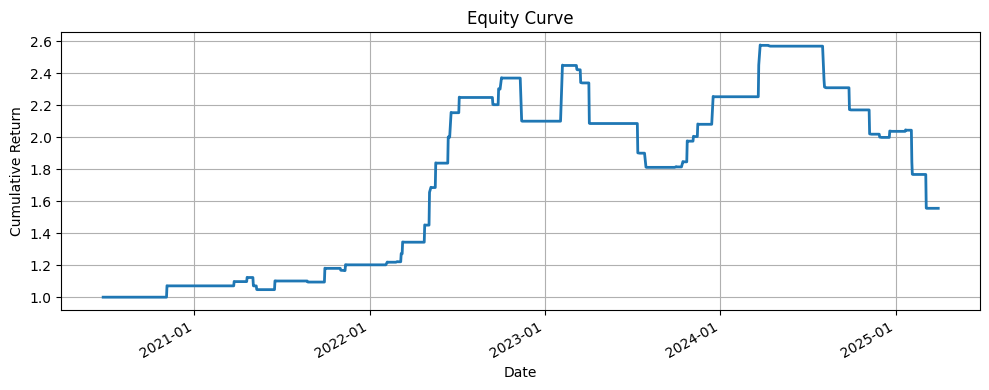

In [25]:
# In[3]: Plot equity curve with proper DateTime axis
# (same as before)

if not pd.api.types.is_datetime64_any_dtype(results.index):
    mask = results.index.astype(str) != "Date"
    results = results.loc[mask]
    results.index = pd.to_datetime(results.index, errors="coerce")
    results = results[~results.index.isna()]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(results.index, results["equity"], linewidth=2)
ax.set_title("Equity Curve")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")
ax.grid(True)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


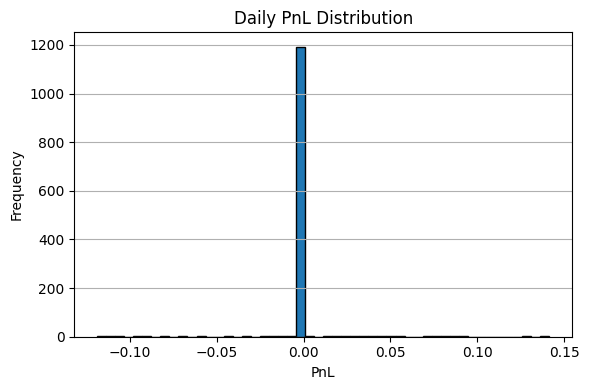

In [26]:
# In[4]: Plot histogram of daily PnL
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(results["pnl"], bins=50, edgecolor="black")
ax.set_title("Daily PnL Distribution")
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.grid(axis="y")
plt.tight_layout()
plt.show()


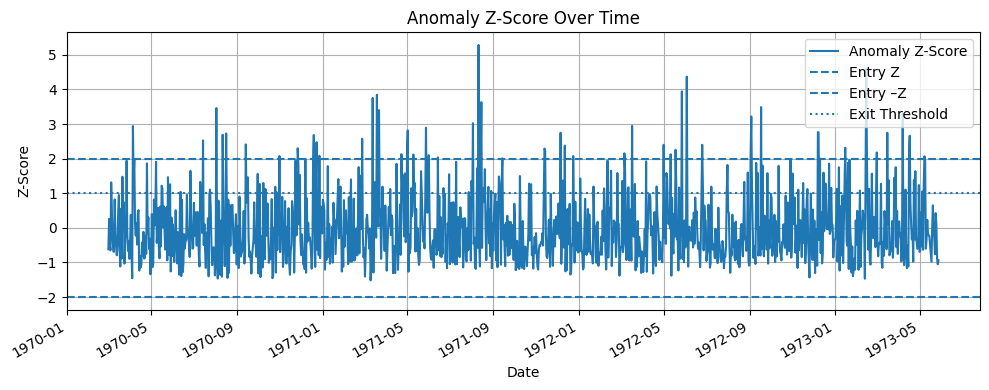

In [27]:
# In[5]: Plot anomaly z-score with thresholds
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(anomaly.index, anomaly.values, label="Anomaly Z-Score")
ax.axhline(engine.entry_z,   linestyle="--", label="Entry Z")
ax.axhline(-engine.entry_z,  linestyle="--", label="Entry –Z")
ax.axhline(engine.exit_z,    linestyle=":",  label="Exit Threshold")
ax.set_title("Anomaly Z-Score Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Z-Score")
ax.grid(True)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


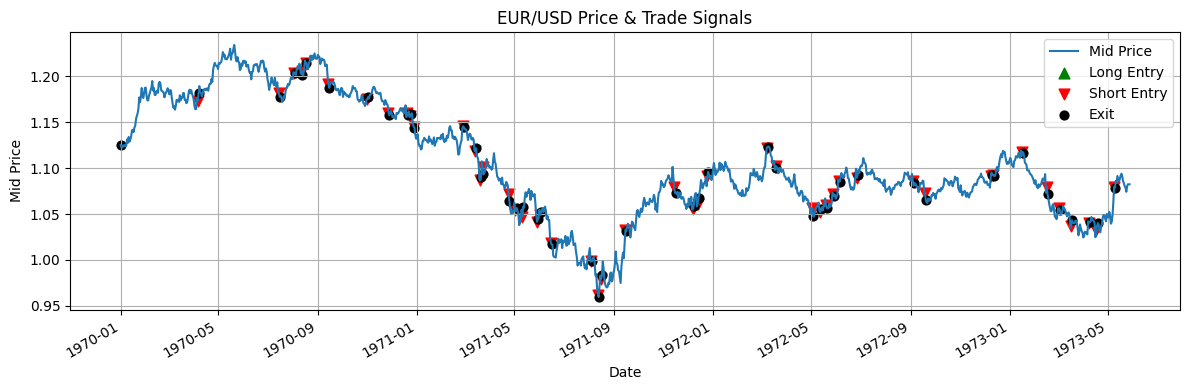

In [28]:
# In[6]: Plot price series with trade markers for one FX pair
pair = "EUR/USD"

price_df = pd.read_csv(
    project_root / "data" / "processed" / "prices.csv",
    index_col="Date", parse_dates=True
)[pair]

common_idx = price_df.index.intersection(engine.signals.index)
price = price_df.loc[common_idx]
sig   = engine.signals[pair].reindex(common_idx).fillna(0)

entries_long  = (sig ==  1) & (sig.shift(1) !=  1)
entries_short = (sig == -1) & (sig.shift(1) != -1)
exits         = (sig ==  0) & (sig.shift(1) !=  0)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(price.index, price.values, label="Mid Price", linewidth=1.5)
ax.scatter(price.index[entries_long],  price[entries_long],
           marker="^", color="green", s=60, label="Long Entry")
ax.scatter(price.index[entries_short], price[entries_short],
           marker="v", color="red",   s=60, label="Short Entry")
ax.scatter(price.index[exits],         price[exits],
           marker="o", color="black", s=40, label="Exit")

ax.set_title(f"{pair} Price & Trade Signals")
ax.set_xlabel("Date")
ax.set_ylabel("Mid Price")
ax.grid(True)
ax.legend(loc="best")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
